# Multilevel hierarchical Bayesian modeling of cross-national factors in SUV sales

## Fourth Model - Model with Student T-Distribution and calculated unique Alpha values

In [ ]:
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

from cmdstanpy import CmdStanModel
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import arviz as az
import seaborn as sns
from scipy.stats import lognorm, norm, expon

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

CmdStan install directory: /root/.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation
CmdStan install directory: /root/.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation


## Auxiliary Functions

In [ ]:
def plot_suv_sales_world_map(countries: np.ndarray, sales: np.ndarray, isPred: bool) -> None:
    """
    Plots a map showing the distribution of SUV sales across the world.

    Parameters:
    - countries (np.ndarray): Array of country names corresponding to the sales data.
    - sales (np.ndarray): Array of sales figures corresponding to each country.
    - isPred (bool): Flag to determine whether the sales data includes predictions. If True, the sales
      data is averaged across all predictions before plotting.

    Returns:
    - None: This function directly displays the plot and does not return any value.
    """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    if isPred:
        sales = np.mean(sales, axis=0)

    sales_data = pd.DataFrame({
        'country': countries,
        'SUV_sales': sales
    })

    world_with_sales = world.merge(sales_data, how='left', left_on='name', right_on='country')

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    plt.title('World Map of SUV Sales', fontsize=16)
    world_with_sales.boundary.plot(ax=ax, linewidth=1, color='black')

    vmin, vmax = 0, 1

    world_with_sales.plot(
        column='SUV_sales',
        ax=ax,
        legend=False,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={'color': 'lightgrey', "label": "No Data"},
        cmap='Blues'
    )

    cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])

    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Fraction of SUV Sales by Country', fontsize=14, labelpad=20)
    cbar.ax.tick_params(labelsize=10)

    plt.show()

In [ ]:
def plot_bar_graph_country_suv_sales(df: pd.DataFrame) -> None:
    """
    Plots a bar graph of actual SUV sales by country.

    Parameters:
    - df (pd.DataFrame): DataFrame with at least two columns: 'country' and 'SUV_sales'.
      'country' column contains the names of the countries as strings.
      'SUV_sales' column contains the sales figures as floats.

    Returns:
    - None: The function directly displays the plot and does not return any value.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    N = df.shape[0]
    real_sales = df['SUV_sales'].values
    country_names = df['country'].values
    samples = np.arange(N) + 1

    fig, ax = plt.subplots(figsize=(15, 5))

    bars = ax.bar(samples, real_sales*100, width=0.4, color='tab:blue', alpha=0.7, edgecolor='black')

    ax.set_xlabel('Country', fontsize=12)
    ax.set_ylabel('SUV Sales', fontsize=12)
    ax.set_title('Actual SUV Sales by Country', fontsize=14)
    ax.legend(['SUV Sales'], fontsize='small')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_xticks(samples)
    ax.set_xticklabels(country_names, rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.2f} %', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
def comparison_plot_for_prior(predicted_sales: np.ndarray, dataframe: pd.DataFrame) -> None:
    """
    Plots a histogram comparison for predicted SUV sales versus observed sales across multiple countries.

    Parameters:
    - predicted_sales (np.ndarray): Array of predicted sales figures corresponding to each country.
    - dataframe (pd.DataFrame): DataFrame with at least two columns: 'country' and 'SUV_sales'.
      'country' column contains the names of the countries as strings.
      'SUV_sales' column contains the sales figures as floats.

    Returns:
    - None: The function directly displays the plot and does not return any value.
    """
    country_list = dataframe['country'].values
    N = len(country_list)

    num_rows = (N + 2) // 3
    num_cols = min(N, 3)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))
    axs = axs.ravel()

    for i in range(N):
        axs[i].hist(predicted_sales[:, i], bins=30, alpha=0.7, edgecolor='black', label='Prior')
        axs[i].axvline(dataframe["SUV_sales"][i+1], color='r', label=f'Obs - {dataframe["SUV_sales"][i+1]}')
        axs[i].set_title(f'Country: {country_list[i]}', fontsize=16)
        axs[i].legend(fontsize='large')
        axs[i].set_xlabel('Sales', fontsize=14)
        axs[i].set_yticks([])
        axs[i].grid()

    for j in range(N, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def general_comparison_plot(fit_pd: pd.DataFrame, df: pd.DataFrame) -> None:
    """
    Plots a comparison of predicted and actual SUV sales by country, incorporating error bars for the predicted values.

    Parameters:
    - fit_pd (pd.DataFrame): DataFrame containing prediction sales data. Each row corresponds to a sample of predictions.
    - df (pd.DataFrame): DataFrame with at least two columns: 'country' and 'SUV_sales'.
      'country' column contains the names of the countries as strings.
      'SUV_sales' column contains the sales figures as floats.

    Returns:
    - None: The function directly displays the plot and does not return any value.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    N = df.shape[0]
    sales_pred = np.array([fit_pd[f'sales_pred[{i+1}]'] for i in range(N)])
    sales_pred_means = np.mean(sales_pred, axis=1)
    sales_pred_stds = np.std(sales_pred, axis=1)

    real_sales = df['SUV_sales'].values
    country_names = df['country'].values
    samples = np.arange(N) + 1

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(samples, real_sales, width=0.4, color='tab:blue', alpha=0.7, label='Real Sales', edgecolor='black')
    ax.errorbar(samples, sales_pred_means, yerr=sales_pred_stds, fmt='o', color='black', ecolor='black', capsize=5, label='Pred. Sales with Pred. Std. Dev.')
    ax.set_xlabel('Country', fontsize=14)
    ax.set_ylabel('SUV Sales', fontsize=14)
    ax.set_title('Comparison of Predicted and Actual SUV Sales by Country', fontsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    ax.set_xticks(samples)
    ax.set_xticklabels(country_names, rotation=90, ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

## Basic Dataset


*   Downloading data file from Google Drive
*   Creating a Dataframe with the sheet data
*   Initial data preprocessing

To run that code you need to export the `SUV_Sales_basic_dataset.csv` file from [SUV Sales Determination Dataset](https://github.com/sukiennik-monika/SUV-Sales-Determination-Dataset) to Google Sheets, integrated this Google Collaboratory.

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('da_dataset').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)

df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.iloc[:,:-1]
df = df.apply(lambda x: x.str.replace(',','.'))
df['country'].replace({
    'United States': 'United States of America',
    'Czech Republic': 'Czechia'
}, inplace=True)
df['SUV_sales'] = df['SUV_sales'].astype(float) / 100
df.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price,fertility_rate,,
1,Albania,0.4007,3.90,70.80,404.02,2.09,1.60,,
2,Argentina,0.1613,3.60,30.00,427.94,0.90,2.20,,
3,Australia,0.5065,4.90,6.00,4218.89,1.35,1.80,,
4,Austria,0.4296,6.00,73.80,2175.48,1.87,1.50,,
5,Belgium,0.4395,4.40,4.40,2354.96,1.98,1.60,,


* Changing all rows data type to float

In [ ]:
df = df.astype({'SUV_sales':'float',
                'roads_quality':'float',
                'mountains':'float',
                'wage':'float',
                'fuel_price':'float',
                'fertility_rate':'float'})

* Data rescaling using min-max normalization method

In [ ]:
df['minmax_wage'] = (df.wage - df.wage.min()) / (df.wage.max() - df.wage.min())
df['minmax_roads_quality'] = (df.roads_quality - df.roads_quality.min()) / (df.roads_quality.max() - df.roads_quality.min())
df['minmax_mountains'] = (df.mountains - df.mountains.min()) / (df.mountains.max() - df.mountains.min())
df['minmax_fuel_price'] = (df.fuel_price - df.fuel_price.min()) / (df.fuel_price.max() - df.fuel_price.min())
df.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price,fertility_rate,,,minmax_wage,minmax_roads_quality,minmax_mountains,minmax_fuel_price
1,Albania,0.4007,3.9,70.8,404.02,2.09,1.6,,,0.015395,0.264706,0.846890,0.886486
2,Argentina,0.1613,3.6,30.0,427.94,0.90,2.2,,,0.019500,0.176471,0.358852,0.243243
3,Australia,0.5065,4.9,6.0,4218.89,1.35,1.8,,,0.669994,0.558824,0.071770,0.486486
4,Austria,0.4296,6.0,73.8,2175.48,1.87,1.5,,,0.319362,0.882353,0.882775,0.767568
5,Belgium,0.4395,4.4,4.4,2354.96,1.98,1.6,,,0.350160,0.411765,0.052632,0.827027


* Plot of a world map with SUV sales data from the dataset

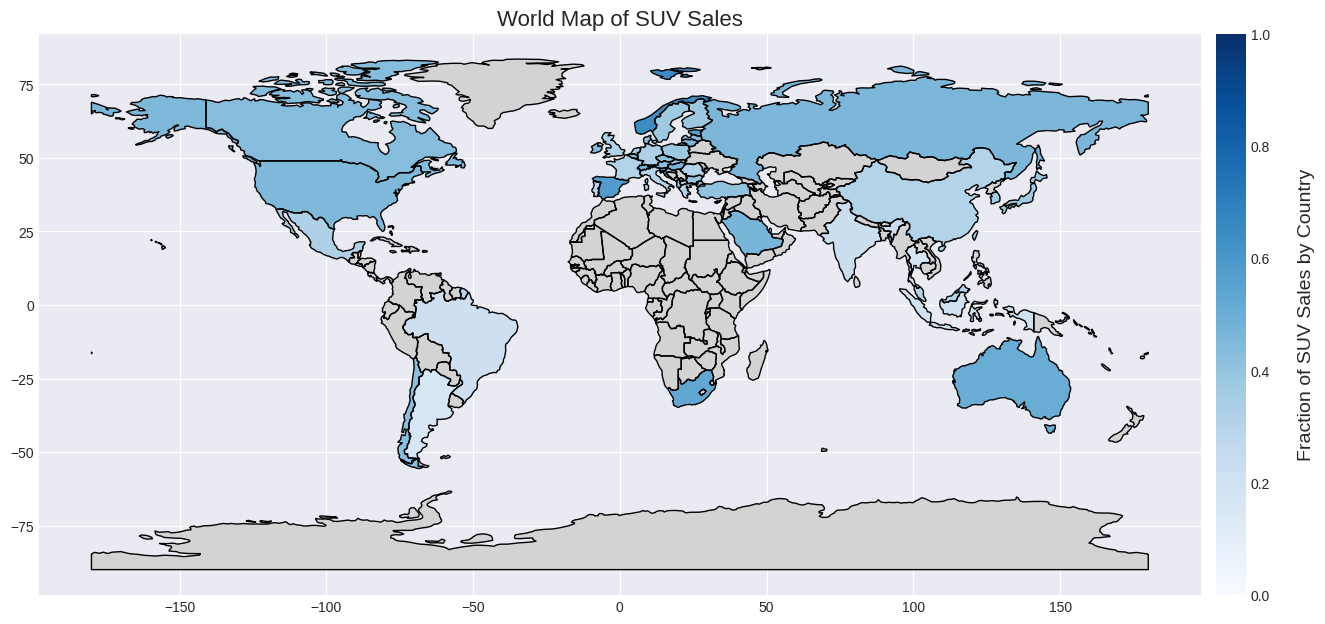

In [ ]:
plot_suv_sales_world_map(df['country'].values, df['SUV_sales'].values, False)

## G20 Countries Dataset

*   Downloading G20 data file from Google Drive
*   Creating a Dataframe with the sheet data
*   Initial data preprocessing

To run that code you need to export the `SUV_sales_g20_dataset.csv` file from [SUV Sales Determination Dataset](https://github.com/sukiennik-monika/SUV-Sales-Determination-Dataset) to Google Sheets, integrated this Google Collaboratory.

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('da_dataset_g20').sheet1
rows = worksheet.get_all_values()
df_g20 = pd.DataFrame.from_records(rows)

df_g20.columns = df_g20.iloc[0]
df_g20 = df_g20.iloc[1:]
df_g20 = df_g20.iloc[:,:-1]
df_g20 = df_g20.apply(lambda x: x.str.replace(',','.'))
df_g20['country'].replace({
    'United States': 'United States of America'
}, inplace=True)
df_g20['SUV_sales'] = df_g20['SUV_sales'].astype(float) / 100
df_g20.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price
1,Argentina,0.1613,3.60,30.00,427.94,0.90
2,Australia,0.5065,4.90,6.00,4218.89,1.35
3,Brazil,0.2182,3.00,30.00,402.77,1.29
4,Canada,0.4300,5.00,24.00,3338.62,1.18
5,China,0.3098,4.60,33.00,1122.36,1.19


* Changing all rows data type to float

In [ ]:
df_g20 = df_g20.astype({'SUV_sales':'float',
                'roads_quality':'float',
                'mountains':'float',
                'wage':'float',
                'fuel_price':'float'})

* Data rescaling using min-max normalization method

In [ ]:
df_g20['minmax_wage'] = (df_g20.wage - df_g20.wage.min()) / (df_g20.wage.max() - df_g20.wage.min())
df_g20['minmax_roads_quality'] = (df_g20.roads_quality - df_g20.roads_quality.min()) / (df_g20.roads_quality.max() - df_g20.roads_quality.min())
df_g20['minmax_mountains'] = (df_g20.mountains - df_g20.mountains.min()) / (df_g20.mountains.max() - df_g20.mountains.min())
df_g20['minmax_fuel_price'] = (df_g20.fuel_price - df_g20.fuel_price.min()) / (df_g20.fuel_price.max() - df_g20.fuel_price.min())
df_g20.head()

,country,SUV_sales,roads_quality,mountains,wage,fuel_price,minmax_wage,minmax_roads_quality,minmax_mountains,minmax_fuel_price
1,Argentina,0.1613,3.6,30.0,427.94,0.90,0.029104,0.193548,0.342105,0.190789
2,Australia,0.5065,4.9,6.0,4218.89,1.35,1.000000,0.612903,0.026316,0.486842
3,Brazil,0.2182,3.0,30.0,402.77,1.29,0.022658,0.000000,0.342105,0.447368
4,Canada,0.4300,5.0,24.0,3338.62,1.18,0.774555,0.645161,0.263158,0.375000
5,China,0.3098,4.6,33.0,1122.36,1.19,0.206951,0.516129,0.381579,0.381579


* Plot of a bar graph with SUV sales data from the dataset

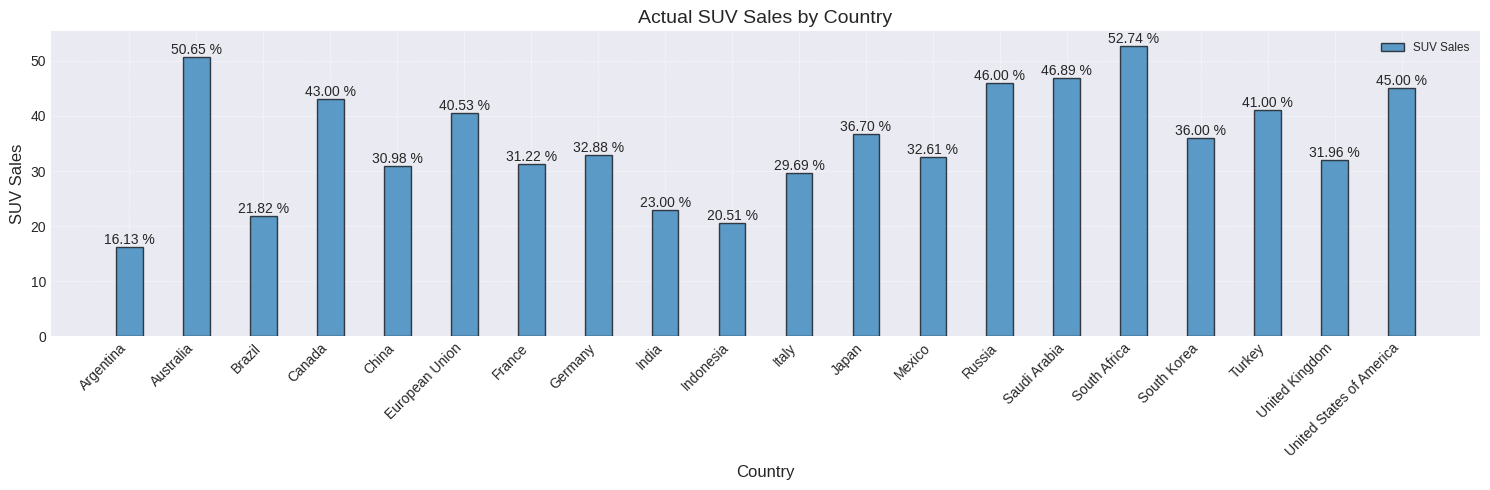

In [ ]:
plot_bar_graph_country_suv_sales(df_g20)

## Prior predictive check for basic countries

* Prior predictive check model structure

In [ ]:
all_ppc_nc_st_ua_code = """
                        data {
                        int N;
                        vector[N] mountains;
                        vector[N] roads_quality;
                        vector[N] fuel_price;
                        vector[N] wage;
                      }

                      generated quantities {
                        real beta_mountains = normal_rng(0, 0.25);
                        real beta_roads_quality = normal_rng(0, 0.25);
                        real beta_fuel_price = normal_rng(0, 0.25);
                        real beta_wage = normal_rng(0, 0.25);
                        real <lower = 0> sigma = abs(normal_rng(0, 0.01));
                        real <lower = 0> df = abs(normal_rng(0, 20));
                        real <lower = 0> gamma_param = abs(normal_rng(0,1));
                        real <lower = 0> delta_param = abs(normal_rng(0,.1));

                        vector[N] sales_pred;
                        vector[N] mu;
                        vector[N] alpha;

                        for (i in 1:N) {
                            alpha[i] = normal_rng(gamma_param, delta_param);
                            mu[i] = alpha[i] +
                                  wage[i] * beta_wage +
                                  fuel_price[i] * beta_fuel_price +
                                  roads_quality[i] * beta_roads_quality +
                                  mountains[i] * beta_mountains;

                            sales_pred[i] = student_t_rng(df+2, mu[i], sigma);
                        }
                      }
"""

with open('all_ppc_nc_st_ua.stan', 'w') as file:
    file.write(all_ppc_nc_st_ua_code)

* Preparing a dictionary for a sampling method input with random values from the real values range
* Creating CmdStanModel with prior predicitve check model structure
* Sampling model with random values

In [ ]:
data_sim_all_nc = {'N': 49,
                'mountains': np.linspace(df['minmax_mountains'].min(), df['minmax_mountains'].max(), 49),
                'roads_quality': np.linspace(df['minmax_roads_quality'].min(), df['minmax_roads_quality'].max(), 49),
                'fuel_price': np.linspace(df['minmax_fuel_price'].min(), df['minmax_fuel_price'].max(), 49),
                'wage': np.linspace(df['minmax_wage'].min(), df['minmax_wage'].max(), 49)
                }

all_ppc_nc_st_ua = "all_ppc_nc_st_ua.stan"

model_mr = CmdStanModel(stan_file = all_ppc_nc_st_ua)

R = 1000
sim_all_nc_st_ua = model_mr.sample(data=data_sim_all_nc,
                  iter_sampling=R,
                  iter_warmup=1,
                  chains=1,
                  fixed_param=True,
                  show_progress=True,
                  seed=29042020)

y_pred_all_nc_st_ua = sim_all_nc_st_ua.stan_variable('sales_pred')

chain 1 |          | 00:00 Status

* Plot of comparison sales as prior predictive check model output histogram and real sales value for each country

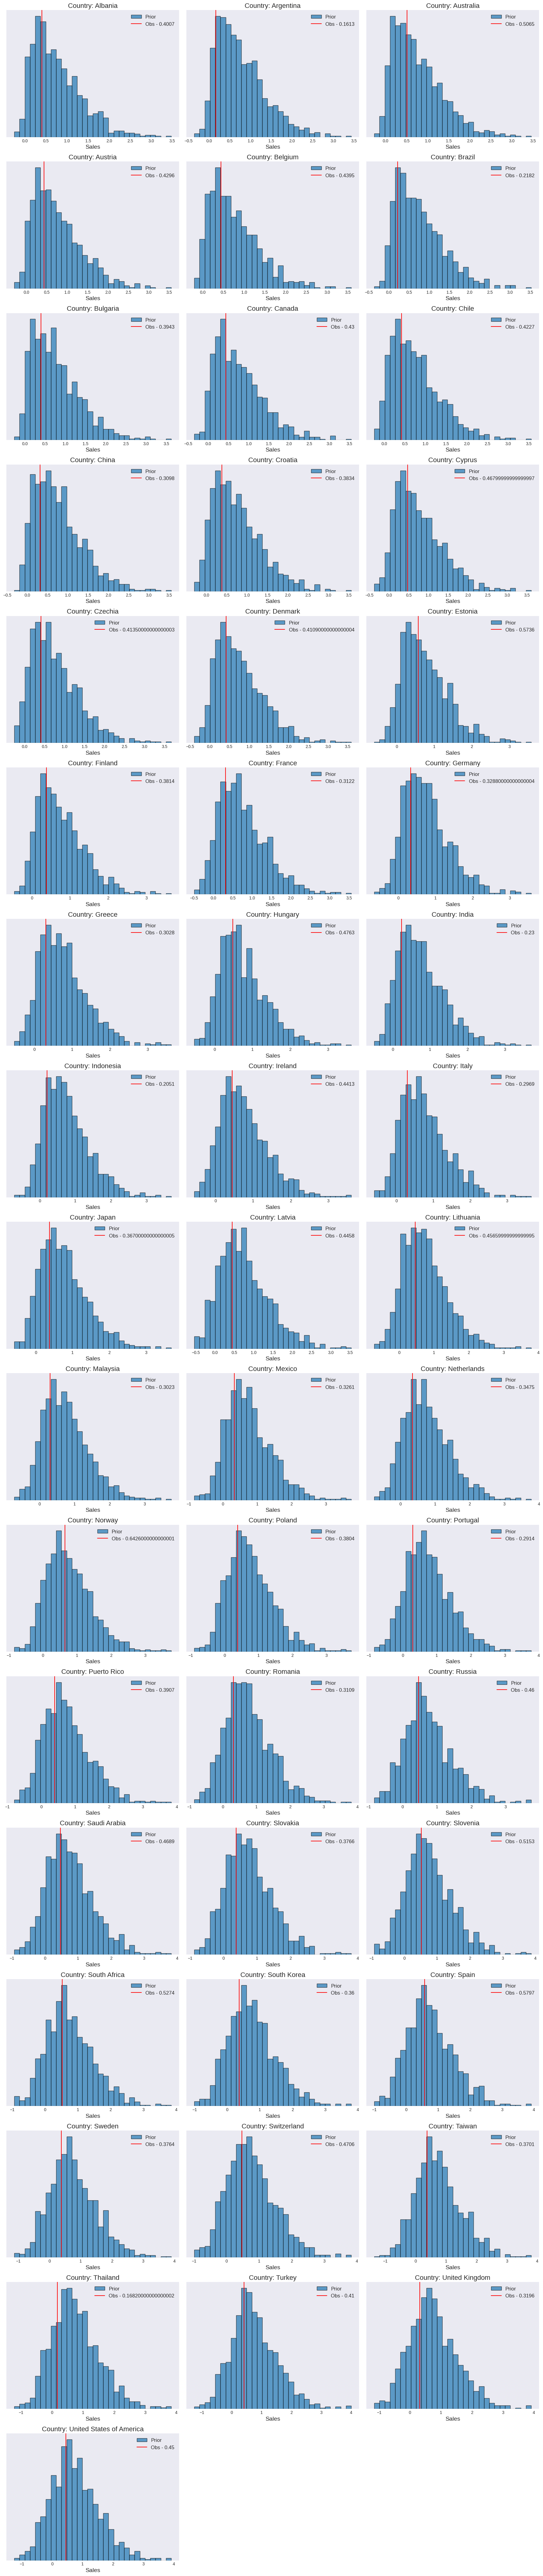

In [ ]:
comparison_plot_for_prior(y_pred_all_nc_st_ua, df)

## Prior predictive check for G20 countries

* Preparing a dictionary for a sampling method input with random values from the real values range
* Creating CmdStanModel with prior predicitve check model structure
* Sampling model with random values

In [ ]:
data_sim_all_nc_g20 = {'N': 20,
                'mountains': np.linspace(df_g20['minmax_mountains'].min(), df_g20['minmax_mountains'].max(), 20),
                'roads_quality': np.linspace(df_g20['minmax_roads_quality'].min(), df_g20['minmax_roads_quality'].max(), 20),
                'fuel_price': np.linspace(df_g20['minmax_fuel_price'].min(), df_g20['minmax_fuel_price'].max(), 20),
                'wage': np.linspace(df_g20['minmax_wage'].min(), df_g20['minmax_wage'].max(), 20)
                }

R = 1000
sim_all_nc_st_ua_g20 = model_mr.sample(data=data_sim_all_nc_g20,
                  iter_sampling=R,
                  iter_warmup=1,
                  chains=1,
                  fixed_param=True,
                  show_progress=True,
                  seed=29042020)

y_pred_all_nc_st_ua_g20 = sim_all_nc_st_ua_g20.stan_variable('sales_pred')

chain 1 |          | 00:00 Status

* Plot of comparison sales as prior predictive check model output histogram and real sales value for each country

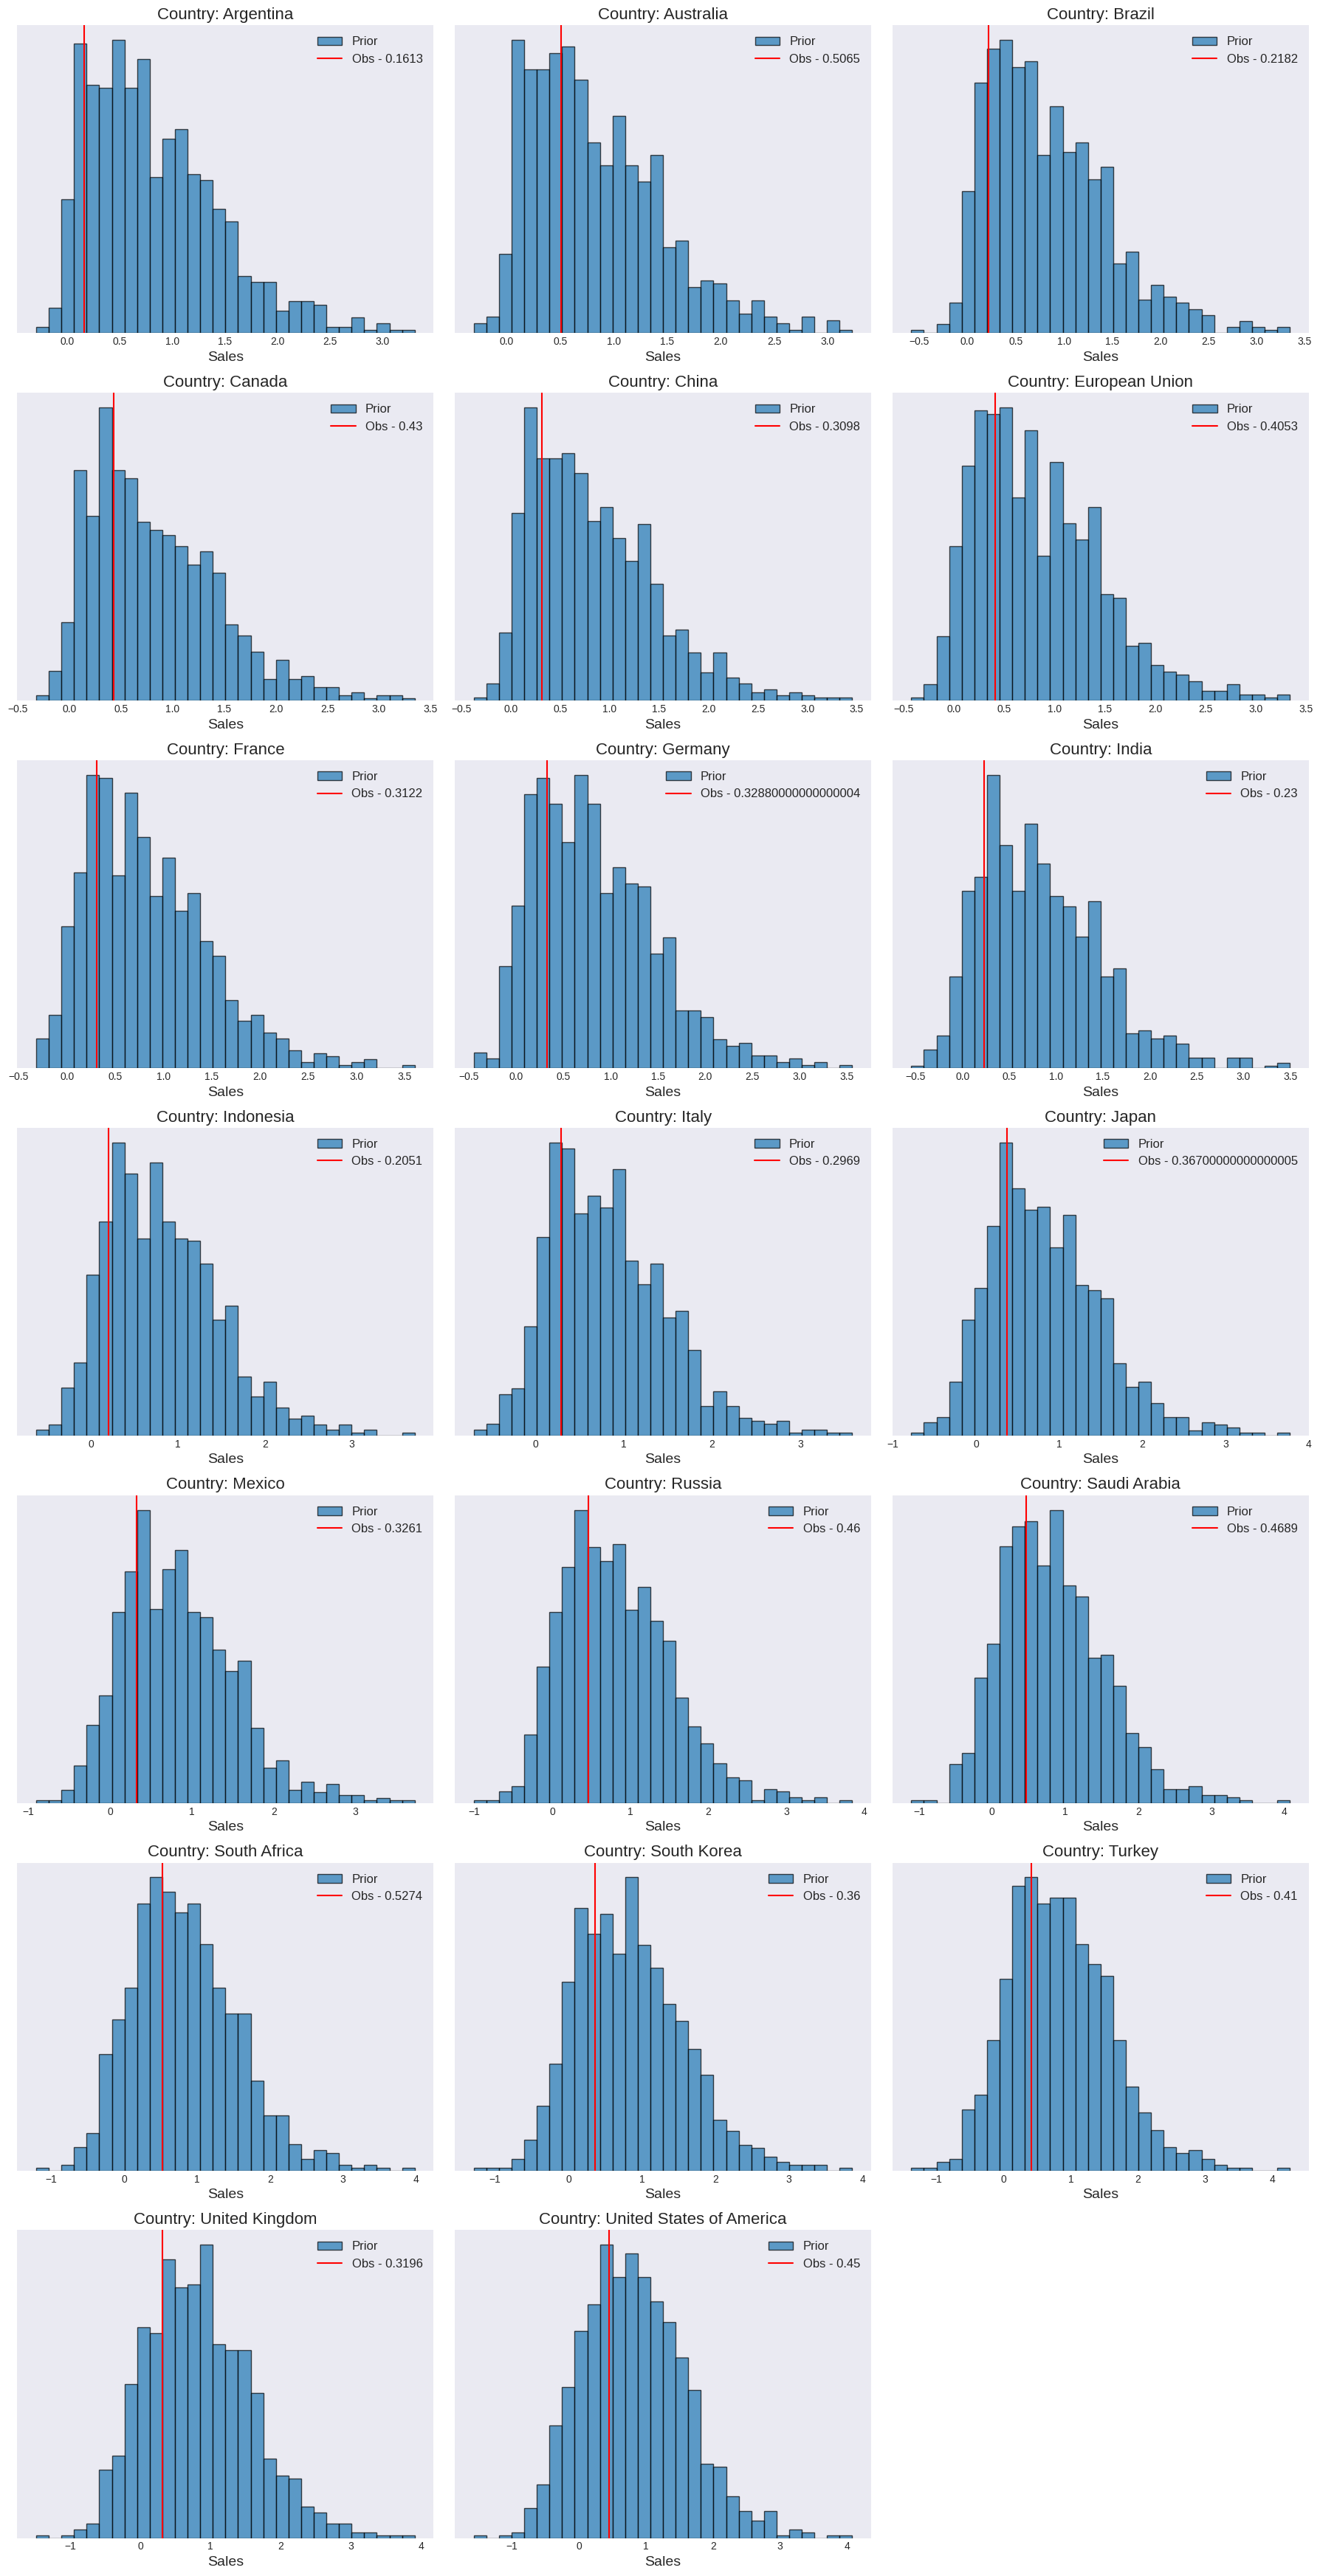

In [ ]:
comparison_plot_for_prior(y_pred_all_nc_st_ua_g20, df_g20)

## Model Structure

Structure of model with student t-distribution and calculated unique alpha values

In [ ]:
model_all_param_not_cen_st_ua_code = """
                        data {
                          int<lower=1> N;                // Number of data points
                          vector[N] sales;               // SUV car sales
                          vector[N] roads_quality;       // Roads quality
                          vector[N] mountains_area;      // Mountains area per country
                          vector[N] wages;               // Average wage
                          vector[N] fuel_price;          // Fuel prices
                        }

                        parameters {
                          vector[N] alpha;
                          real<lower=0> beta_fuel_price;             // Coefficient for fuel prices
                          real<lower=0> beta_wage;                   // Coefficient for average wage
                          real<lower=0> beta_roads_quality;          // Coefficient for roads quality
                          real<lower=0> beta_mountains;              // Coefficient for mountains area
                          real<lower=0.01> sigma;                    // Standard deviation
                          real <lower = 0> df;                       // Degrees of freedom
                          real<lower=0> gamma_param;                 // First param for the alpha
                          real<lower=0.01> delta_param;              // Second param for the alpha
                        }

                        transformed parameters {
                          vector[N] mu;

                          for (i in 1:N) {
                            mu[i] = alpha[i] +
                                wages[i] * beta_wage +
                                fuel_price[i] * beta_fuel_price +
                                roads_quality[i] * beta_roads_quality +
                                mountains_area[i] * beta_mountains;
                            }
                        }

                        model {
                          // Priors
                          beta_fuel_price ~ normal(0, 0.25);
                          beta_wage ~ normal(0, 0.25);
                          beta_roads_quality ~ normal(0, 0.25);
                          beta_mountains ~ normal(0, 0.25);
                          sigma ~ normal(0, 0.01);
                          df ~ normal(0,20);
                          gamma_param ~ normal(0,1);
                          delta_param ~ normal(0,.1);
                          alpha ~ normal(gamma_param, delta_param);

                          sales ~ student_t(df+2, mu, sigma);
                        }

                        generated quantities {
                          vector[N] sales_pred;
                          vector[N] log_likelihood;

                          for (i in 1:N) {
                            sales_pred[i] = student_t_rng(df+2, mu[i], sigma);
                            log_likelihood[i] = student_t_lpdf(sales[i] | df+2, mu[i], sigma);
                          }
                        }
"""

with open('model_all_param_not_cen_st_ua.stan', 'w') as file:
    file.write(model_all_param_not_cen_st_ua_code)

## Model Sampling for basic countries

* Preparing a dictionary for a sampling method input with dataset values
* Creating CmdStanModel with model structure
* Sampling model with dataset values

In [ ]:
data2 = dict(
    N=len(df),
    sales=df.SUV_sales.values,
    roads_quality=df.minmax_roads_quality.values,
    mountains_area=df.minmax_mountains.values,
    wages=df.minmax_wage.values,
    fuel_price=df.minmax_fuel_price.values)

model2_nc_st_ua = CmdStanModel(stan_file='model_all_param_not_cen_st_ua.stan')
fit2_nc_st_ua = model2_nc_st_ua.sample(data=data2,
                           seed=28052020,
                           iter_sampling=4000,
                           show_progress=True)

sales_pred_all_nc_st_ua = fit2_nc_st_ua.stan_variable('sales_pred')
d2_nc_st_ua = fit2_nc_st_ua.draws_pd()

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

* Plot of a bar graph with comparison of actual and predicted SUV sales with error bars by country

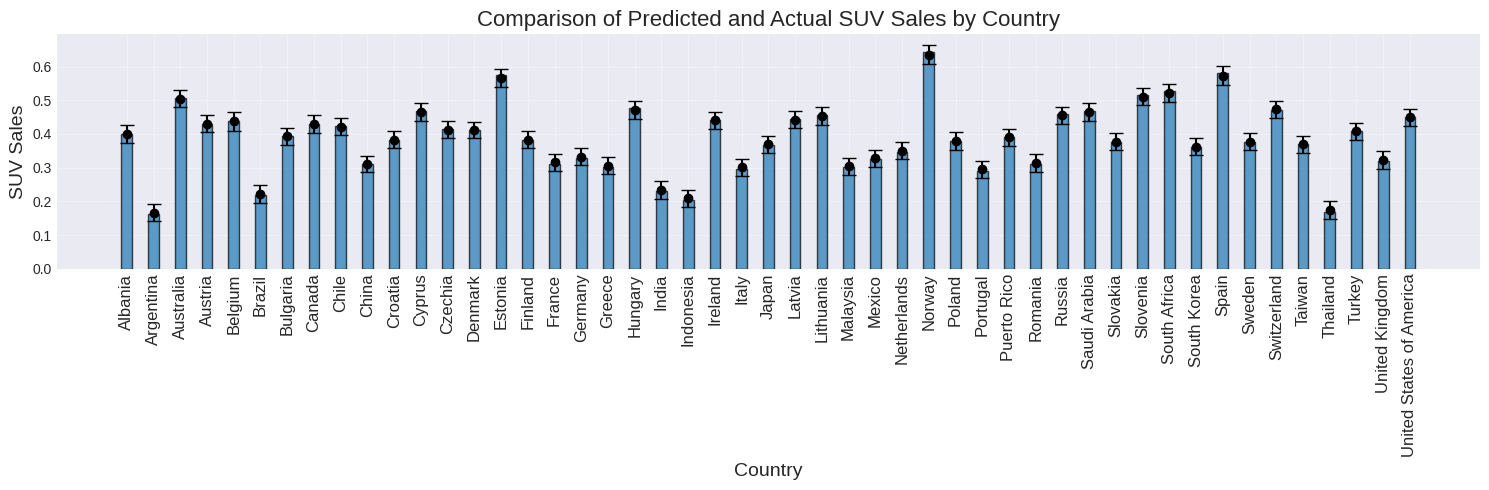

In [ ]:
general_comparison_plot(d2_nc_st_ua, df)

* Plot of a world map with predicted SUV sales data from the model

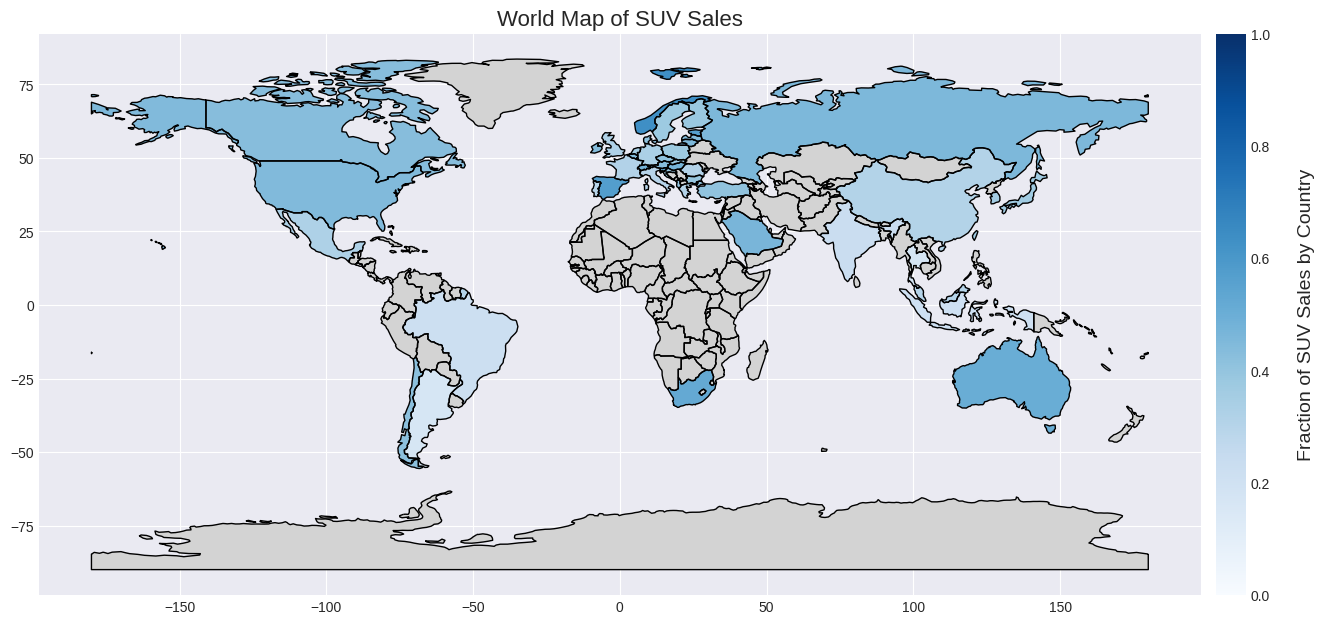

In [ ]:
plot_suv_sales_world_map(df['country'].values, sales_pred_all_nc_st_ua, True)

## Model Sampling for G20 countries

* Preparing a dictionary for a sampling method input with G20 dataset values
* Creating CmdStanModel with model structure
* Sampling model with G20 dataset values

In [ ]:
data2_g20 = dict(
    N=len(df_g20),
    sales=df_g20.SUV_sales.values,
    roads_quality=df_g20.minmax_roads_quality.values,
    mountains_area=df_g20.minmax_mountains.values,
    wages=df_g20.minmax_wage.values,
    fuel_price=df_g20.minmax_fuel_price.values)

fit2_nc_st_ua_g20 = model2_nc_st_ua.sample(data=data2_g20,
                           seed=28052020,
                           iter_sampling=4000,
                           show_progress=True)

d2_nc_st_ua_g20 = fit2_nc_st_ua_g20.draws_pd()

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

* Plot of a bar graph with comparison of actual and predicted SUV sales with error bars by country

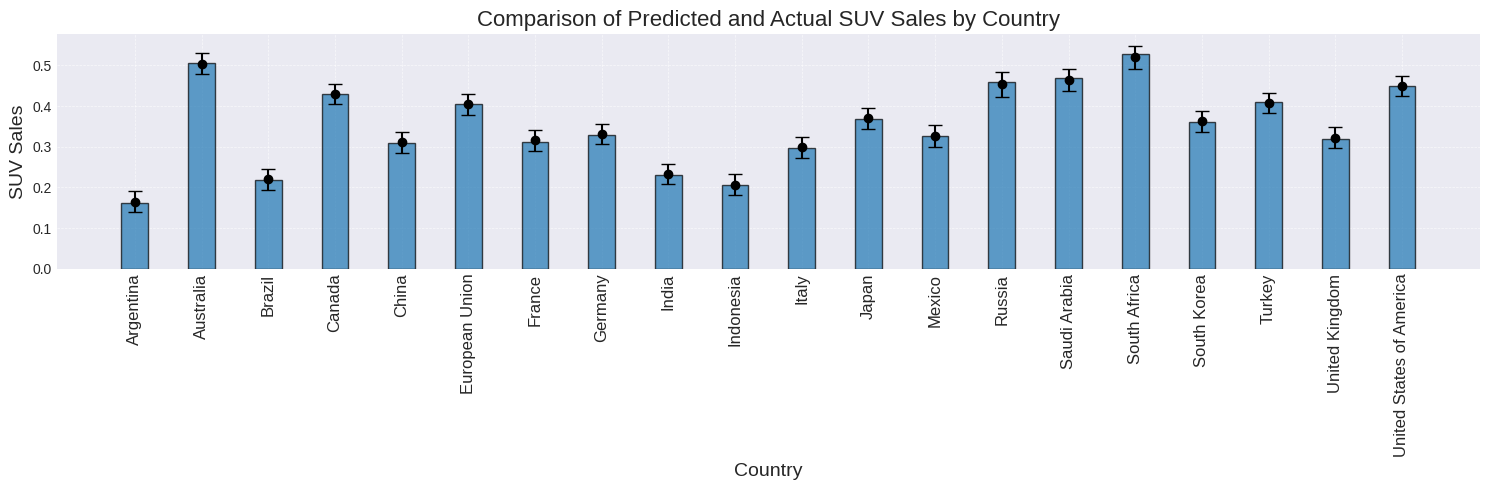

In [ ]:
general_comparison_plot(d2_nc_st_ua_g20, df_g20)